# COGS 108 - EDA Checkpoint

# Names

- Bridget Egan 
- Dillan Merchant
- Jennifer Hang
- Sam Zakeri
- Connie Chang

# Research Question

**How are American news headline sentiments correlated to their publication source's political leanings?** To do this, we wanted three sources that reflected 'far-left', 'centrist', and 'far-right' political leanings. Using both AllSides and MediaBiasFactCheck, Breitbart was evaluated as the most right-leaning news source of our dataset, CNN was evaluated as the most left-leaning news source, and NPR was evaluated as the most politically-centrist news source [1, 2, 3, 4, 5, 6, 7]. *We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative-- bimodal distribution), and the more centrist news source, NPR, will be more neutral in sentiment.*
- [1] https://www.allsides.com/news-source/cnn-media-bias
- [2] https://mediabiasfactcheck.com/cnn/
- [3] https://mediabiasfactcheck.com/npr/
- [4] https://www.allsides.com/news-source/npr-media-bias
- [5] https://www.allsides.com/news-source/breitbart
- [6] https://mediabiasfactcheck.com/breitbart/
- [7] https://www.adfontesmedia.com/static-mbc/

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk import word_tokenize, sent_tokenize, tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/began/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Cleaning

The data is fairly clean to begin with, there are few missing values and the format is consistent throughout. The issue we have is there is a lot of data that we do not need to use. So, to get our data into a useable format, we will only select the three publications we plan to use, Breitbart, CNN, and NPR, and keep the dates and headlines from only 1,000 of each. We decided on 1,000 of each because the dataset had a higher number of Breitbart articles than any other publication, and we wanted there to be a standard number of headlines for each source. Given that we plan on doing the additional step of sentiment analysis after this data checkpoint, most of our EDA will come next week, and so data distribution checking or data transformations will not be necessary at this time. It is also possible that as this project proceeds, we may decide to add in more points of data analysis, such as increasing how many articles we analyze from each news source, or even adding in different news sources to give us data for a 'center-right' and 'center-left source', if we feel that would improve the strength of our project.

In [2]:
#this imports the relevant data sets from three separate files, and sanitizes the input.

news1 = pd.read_csv('csv_files/articles1.csv', engine = 'python', error_bad_lines=False)
news2 = pd.read_csv('csv_files/articles2.csv', engine = 'python', error_bad_lines=False)
news3 = pd.read_csv('csv_files/articles3.csv', engine = 'python', error_bad_lines=False)


print(news1.shape)
print(news2.shape)
print(news3.shape)

Skipping line 17535: field larger than field limit (131072)
Skipping line 1429: field larger than field limit (131072)
Skipping line 1469: field larger than field limit (131072)
Skipping line 1516: field larger than field limit (131072)
Skipping line 1740: field larger than field limit (131072)
Skipping line 3774: field larger than field limit (131072)
Skipping line 3779: field larger than field limit (131072)
Skipping line 3791: field larger than field limit (131072)
Skipping line 33121: field larger than field limit (131072)
Skipping line 34127: field larger than field limit (131072)


(49999, 10)
(49992, 10)
(42569, 10)


In [3]:
# combine three dataframes into one
news = news1.append(news2).append(news3)
news.shape

(142560, 10)

In [4]:
# check number of articles for each source
news['publication'].value_counts()

Breitbart              23780
New York Post          17493
NPR                    11992
CNN                    11488
Washington Post        11112
Reuters                10710
Guardian                8681
New York Times          7803
Atlantic                7172
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Vox                     4947
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [5]:
#But we only care about the article title, where it comes from, and when it was published(for context of the news)

news_cleaned = news[['title', 'publication', 'date']]
news_cleaned.head()

,title,publication,date
0,House Republicans Fret About Winning Their Hea...,New York Times,2016-12-31
1,Rift Between Officers and Residents as Killing...,New York Times,2017-06-19
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,2017-01-06
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,2017-04-10
4,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,2017-01-02


In [6]:
#Getting rid of all the null columns
news_cleaned = news_cleaned.dropna()
news_cleaned.isnull().values.any()

False

In [7]:
# keep news only from 'Breitbart', 'CNN', and 'NPR'
sources = ['Breitbart', 'CNN', 'NPR']
news = news_cleaned[news_cleaned['publication'].isin(sources)]

news['publication'].value_counts()

Breitbart    23780
NPR          11992
CNN          11488
Name: publication, dtype: int64

### After testing a fair amount, we found that the mean values stabilized at around 2500 samples. 

In [8]:
# pick 2500 random news for each source
news = news.groupby("publication").sample(n=2500)

news['publication'].value_counts()

NPR          2500
Breitbart    2500
CNN          2500
Name: publication, dtype: int64

In [9]:
news.head()

,title,publication,date
25153,"On Rape, Clinton Campaign Deletes ‘You Have Th...",Breitbart,2016-08-15
25276,Colorado Senate Ad Compares Illegal Immigratio...,Breitbart,2016-01-14
31215,Top Hillary Surrogate John Podesta Condemns Vi...,Breitbart,2016-06-03
12076,Populist Outsider Geert Wilders in Combative M...,Breitbart,2017-03-14
25542,Adviser to Pro-Hillary Super PAC: Campaign Nee...,Breitbart,2016-08-09


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [10]:
news['title'] = news['title'].astype(str)

## Lowercase
news['title'] = news['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#remove punct
def remove_punct(string):
    punctuation= '''‘’!()-[]{};:'", <>./?@#$%^&*_~'''
    for x in punctuation:
        string = string.replace(x, " ")
    return string

news['title'] = news['title'].apply(remove_punct)

#tokenize 
news['title'] = news['title'].apply(word_tokenize)

## stop word removal
stop_words = set(stopwords.words('english'))


#We see in the data that Breitbart includes the name of their publication at the end of each of their article titles, as such,
#we decided to add 'breitbart' as a stop word so that it would be removed from the titles, and not dilute the sentiment of the rest
#of the article titles.
stop_words.add('breitbart')
news['title'] = news['title'].apply(lambda x: [item for item in x if item not in stop_words])


##stemming
stemmer = PorterStemmer()
news['title'] = news['title'].apply(lambda x: [stemmer.stem(y) for y in x])

news['tokenized_list'] = news['title']

# putting the tokenized, stemmed, and cleaned titles back into lists
def joiner(title_list): 
    return ' '.join(title_list)
news['title'] = news['title'].apply(joiner)


#Analysing the sentiment of each title and creating a new Dataframe of the compound of the sentiments
analyser = SentimentIntensityAnalyzer()
title_sentences = list(news['title'])
def senti(input_list):
    output = pd.DataFrame()
    for sentence in title_sentences:
        ss = analyser.polarity_scores(sentence)
        ss['cleaned_titles'] = sentence
        output = output.append(ss, ignore_index=True)
    return output


news_sentiments = senti(title_sentences)


In [11]:
#creating a combined dataframe of the titles, their publications, and the compound sentiment of their titles. 
news_sentiments
title_sentiments = pd.DataFrame(news_sentiments['compound']) 

title_sentiments
news = news.reset_index()
news['title_sentiment']  = news_sentiments['compound']
news

,index,title,publication,date,tokenized_list,title_sentiment
0,25153,rape clinton campaign delet right believ websit,Breitbart,2016-08-15,"[rape, clinton, campaign, delet, right, believ...",-0.6908
1,25276,colorado senat ad compar illeg immigr explod t...,Breitbart,2016-01-14,"[colorado, senat, ad, compar, illeg, immigr, e...",0.0000
2,31215,top hillari surrog john podesta condemn violen...,Breitbart,2016-06-03,"[top, hillari, surrog, john, podesta, condemn,...",0.2263
3,12076,populist outsid geert wilder comb mood netherl...,Breitbart,2017-03-14,"[populist, outsid, geert, wilder, comb, mood, ...",0.0000
4,25542,advis pro hillari super pac campaign need disa...,Breitbart,2016-08-09,"[advis, pro, hillari, super, pac, campaign, ne...",0.3612
...,...,...,...,...,...,...
7495,6706,fyre organ use influenc market festiv exist,NPR,2017-05-02,"[fyre, organ, use, influenc, market, festiv, e...",0.0000
7496,12873,outsid zimbabw anti govern pastor take stock m...,NPR,2016-08-21,"[outsid, zimbabw, anti, govern, pastor, take, ...",-0.3182
7497,13234,evolut bred realiti us,NPR,2016-09-06,"[evolut, bred, realiti, us]",0.0000
7498,10530,dee gordon nation leagu reign bat champion get...,NPR,2016-04-29,"[dee, gordon, nation, leagu, reign, bat, champ...",0.5994


### Let us first start with a general exploration of the average sentiments of each news source. Bearing in mind we are randomly choosing 1,000 articles each time this notebook is run, and therefore the averages will vary. 

In [12]:
print("Sentiment Averages for all publications:")
news['title_sentiment'].describe()

Sentiment Averages for all publications:


count    7500.000000
mean       -0.090730
std         0.355774
min        -0.962800
25%        -0.340000
50%         0.000000
75%         0.000000
max         0.906200
Name: title_sentiment, dtype: float64

In [13]:
print('BREITBART, CNN, NPR sentiment averages, respectively:')
news[news['publication'] == 'Breitbart']['title_sentiment'].describe(), news[news['publication'] == 'CNN']['title_sentiment'].describe(), news[news['publication'] == 'NPR']['title_sentiment'].describe()

BREITBART, CNN, NPR sentiment averages, respectively:


(count    2500.000000
 mean       -0.126900
 std         0.372151
 min        -0.956500
 25%        -0.401900
 50%         0.000000
 75%         0.000000
 max         0.906200
 Name: title_sentiment, dtype: float64,
 count    2500.000000
 mean       -0.109565
 std         0.340915
 min        -0.962800
 25%        -0.340000
 50%         0.000000
 75%         0.000000
 max         0.904200
 Name: title_sentiment, dtype: float64,
 count    2500.000000
 mean       -0.035726
 std         0.347011
 min        -0.946800
 25%        -0.250000
 50%         0.000000
 75%         0.000000
 max         0.877900
 Name: title_sentiment, dtype: float64)

### The average total mean of the sentiment distribution is negative, which is to be expected. And everytime we run this notebook, of the news sources, CNN and Breitbart are always more negative, while NPR is the most neutral. But the data could benefit from visual representation. 

### Here begins the visual EDA, with histograms of combined sentiment of all the news sources, then from each specific publication. 

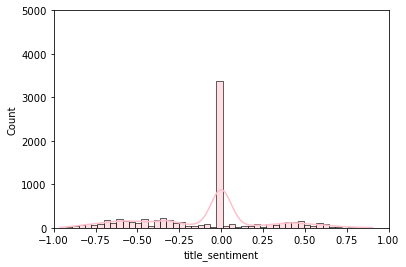

In [14]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');

total_plot.set(ylim=(0,5000));
total_plot.set(xlim=(-1,1));

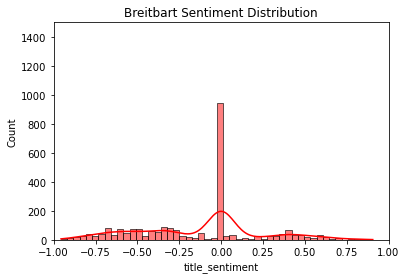

In [15]:
#creating a histogram plot of sentiment distribution based on the composite sentiment 
breitbart = news[news['publication'] == 'Breitbart']
# breitbart.reset_index();
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')

breitbart_plot.set_title("Breitbart Sentiment Distribution")
breitbart_plot.set(ylim=(0,1500))
breitbart_plot.set(xlim=(-1,1));

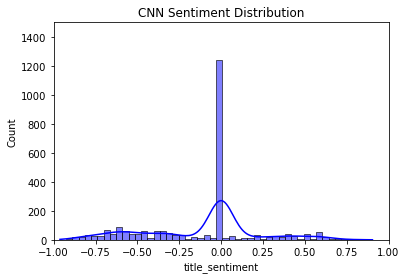

In [16]:
cnn = news[news['publication'] == 'CNN']
# cnn.reset_index();
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');

cnn_plot.set_title("CNN Sentiment Distribution");
cnn_plot.set(ylim=(0,1500));
cnn_plot.set(xlim=(-1,1));

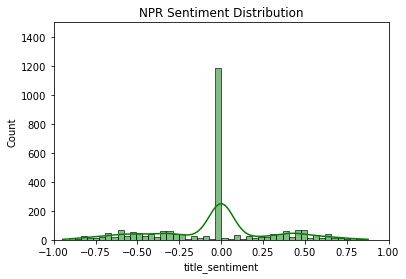

In [17]:
npr = news[news['publication'] == 'NPR']
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');

npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(ylim=(0,1500));
npr_plot.set(xlim=(-1,1));

### For all of these graphs, we can see an obvious similarity, the large column of zero sentiments in the middle. Is this is indicative of the writers of these publications clearly trying to craft the most neutral titles as possible? Or is it that many headlines have complete neutral sentiment due to errors in the stemmer and uses of names? 

### To view the data with a more critical lens, we decided to remove all of the zero sentiments from each of the titles across the board. It is important to note that both NPR and CNN have nearly three hundred more 0 sentiment titles than Breitbart, but we feel that the data can be analyzed adequately without the large column in the middle, and will be able to see the general skew of articles that have more polar sentiment.

In [18]:
#get rid of 0 values (outlier)
news = news[news.title_sentiment != 0]
news.head()
##Pay attention to the words that are not stemmed properly!!

,index,title,publication,date,tokenized_list,title_sentiment
0,25153,rape clinton campaign delet right believ websit,Breitbart,2016-08-15,"[rape, clinton, campaign, delet, right, believ...",-0.6908
2,31215,top hillari surrog john podesta condemn violen...,Breitbart,2016-06-03,"[top, hillari, surrog, john, podesta, condemn,...",0.2263
4,25542,advis pro hillari super pac campaign need disa...,Breitbart,2016-08-09,"[advis, pro, hillari, super, pac, campaign, ne...",0.3612
6,23232,gutfeld trump save whine act like obama,Breitbart,2016-02-03,"[gutfeld, trump, save, whine, act, like, obama]",0.4939
7,9387,california ban travel state less friendli lgbt...,Breitbart,2017-03-15,"[california, ban, travel, state, less, friendl...",-0.5267


### This will probably move the average sentiment to the left, but let's check anyway.

In [19]:
news['title_sentiment'].describe()

count    4145.000000
mean       -0.164168
std         0.465824
min        -0.962800
25%        -0.557400
50%        -0.318200
75%         0.296000
max         0.906200
Name: title_sentiment, dtype: float64

In [20]:
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

print('BREITBART, CNN, NPR sentiment averages, respectively:')
breitbart['title_sentiment'].describe(), cnn['title_sentiment'].describe(), npr['title_sentiment'].describe()

BREITBART, CNN, NPR sentiment averages, respectively:


(count    1557.000000
 mean       -0.203757
 std         0.454709
 min        -0.956500
 25%        -0.557400
 50%        -0.340000
 75%         0.202300
 max         0.906200
 Name: title_sentiment, dtype: float64,
 count    1265.000000
 mean       -0.216531
 std         0.454533
 min        -0.962800
 25%        -0.599400
 50%        -0.340000
 75%         0.202300
 max         0.904200
 Name: title_sentiment, dtype: float64,
 count    1323.000000
 mean       -0.067509
 std         0.474846
 min        -0.946800
 25%        -0.476700
 50%        -0.177900
 75%         0.401900
 max         0.877900
 Name: title_sentiment, dtype: float64)

### By removing the 0column, we about doubled the average mean sentiment across the board: 
   ### -0.127 to -0.204 for Breitbart, 
   ### -0.110 to -0.216 for CNN, and 
   ### -0.036 to -0.068 for NPR. 

### Seeing how this was a uniform transformtion of the data, we feel comfortable analyzing the data without the 0 values moving forward. Let's take a look at the distributions now: 

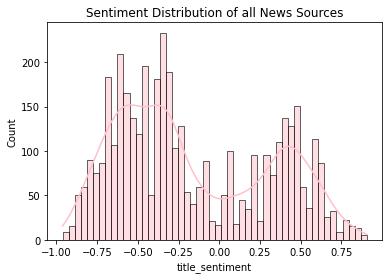

In [21]:
total_plot = sns.histplot(news['title_sentiment'], bins=50, kde=True, color = 'pink');

total_plot.set_title("Sentiment Distribution of all News Sources");

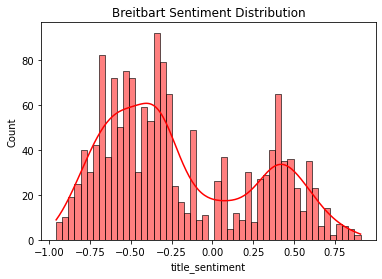

In [22]:
breitbart_plot = sns.histplot(breitbart['title_sentiment'], bins=50, kde=True, color = 'red')

breitbart_plot.set_title("Breitbart Sentiment Distribution");

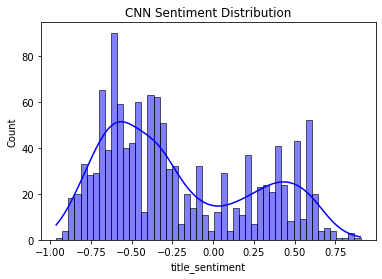

In [23]:
cnn_plot = sns.histplot(cnn['title_sentiment'], bins=50, kde=True, color = 'blue');

cnn_plot.set_title("CNN Sentiment Distribution");

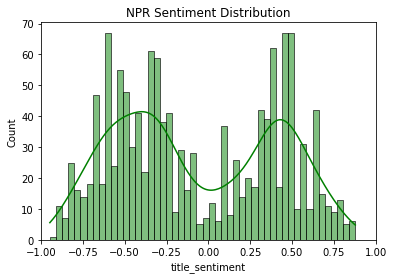

In [24]:
npr_plot = sns.histplot(npr['title_sentiment'], bins=50, kde=True, color = 'green');

npr_plot.set_title("NPR Sentiment Distribution");
npr_plot.set(xlim=(-1,1));

### By removing the column in the middle, we can see a clearer pattern emerge. All of the news sources have an obvious bimodal distribution. But Breitbart and CNN seem to have a skew to the right. 
### So we now combine the graphs to compare the general sentiment distribution of each source.

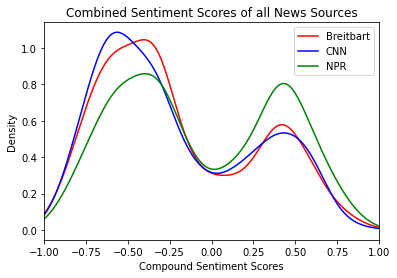

In [25]:
#To combine all the sentiment scores without the 0 sentiment data. 
breitbart = news[news['publication'] == 'Breitbart']
cnn = news[news['publication'] == 'CNN']
npr = news[news['publication'] == 'NPR']

Breitbart = list(breitbart['title'].values)
CNN = list(cnn['title'].values)
NPR = list(npr['title'].values)


# function that will output the dataframe that stores sentiment information
def get_sentiments(input_list):
    output = pd.DataFrame()
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)
    return output

breitbart_sentiments = get_sentiments(Breitbart)
breitbart_sentiments['compound'].plot.density(color = 'red', label = 'Breitbart')

cnn_sentiments = get_sentiments(CNN)
cnn_sentiments['compound'].plot.density(color = 'blue', label = 'CNN')

npr_sentiments = get_sentiments(NPR)
npr_sentiments['compound'].plot.density(color = 'green', label = 'NPR')


plt.legend(loc = 'upper right')
plt.xlabel('Compound Sentiment Scores')
plt.xlim(-1,1);
plt.title("Combined Sentiment Scores of all News Sources");

### By showing all the news sentiment scores on one graph, we can clearly see that CNN and Breitbart have a distinct rightward skew, meaning that the average sentiment of their article titles is more negative than positive. This is in contrast to NPR, which shows a more balanced bimodal distribution with no clear skew to the left or to the right. CNN also seems to be slightly more negative than Breitbart. 


### But we should still ask the question, which words show up the most for all the publications, for each individual publication? Will these words be more negative, positive, or neutral? To do this, we will take the stemmed and stop word removed titles and look at them for the top word frequencies.

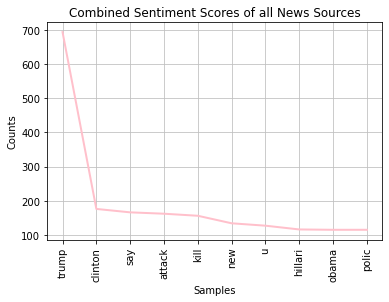

In [26]:
combined_news_publications = news['tokenized_list'].apply(pd.Series).stack()
# calculation word frequency
fdist_most = FreqDist(combined_news_publications)

# Frequency Distribution Plot - top 10 most common words
fdist_most.plot(10, cumulative=False, color = 'pink', title = 'Combined Sentiment Scores of all News Sources');

In [27]:
totalNPR = news['tokenized_list'][(news['publication'] == 'NPR')].apply(pd.Series).stack()
totalCNN = news['tokenized_list'][(news['publication'] == 'CNN')].apply(pd.Series).stack()
totalBreitbart = news['tokenized_list'][(news['publication'] == 'Breitbart')].apply(pd.Series).stack()

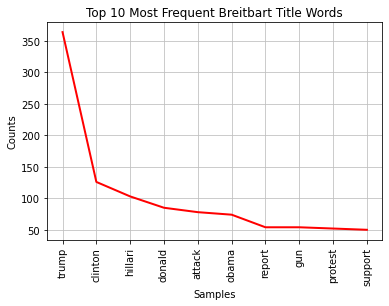

In [28]:
fdist_most = FreqDist(totalBreitbart) 
fdist_most.plot(10, cumulative=False, color = 'red', title = 'Top 10 Most Frequent Breitbart Title Words');

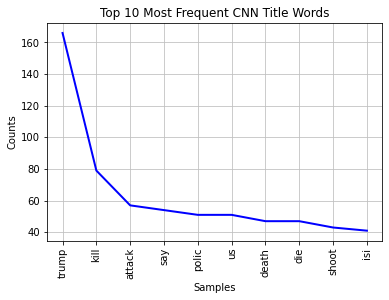

In [29]:
fdist_most = FreqDist(totalCNN) 
fdist_most.plot(10, cumulative=False, color = 'blue', title = 'Top 10 Most Frequent CNN Title Words');

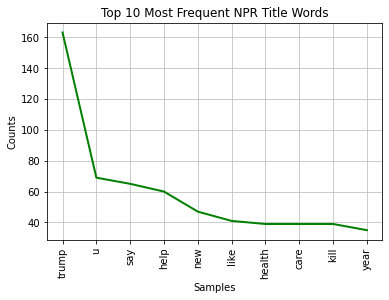

In [30]:
fdist_most = FreqDist(totalNPR) 
fdist_most.plot(10, cumulative=False, color = 'green', title = 'Top 10 Most Frequent NPR Title Words');

### We can see from these most frequent words that the name "Trump" is the most common word used across the publications, which can be ascribed to the time in which the data was collected, starting from the election of 2016 and through his presidency. The rest of the distributions seem to show a propensity for negative words, such as 'kill', 'die', 'attack', and 'death', which can be due to news outlets over-reporting violent events. "Though, it should be noted that NPR seems to have these words further down the list, and CNN has the highest frequency of these 'violent' words. 


### As for our original hypothesis: 
#### "*We hypothesize that the two more politically polar news sources, Breitbart and CNN, will have more polar sentiment (as in frequently positive or negative-- bimodal distribution), and the more centrist news source, NPR, will be more neutral in sentiment.* 
### We feel that our data does support our hypothesis partially. We origianlly predicted that CNN and Breitbart would have a strong bimodal distribution, due to the likely more policially polar nature of their material, and that NPR would be thoroughly neutral, as it is in its political description. NPR did end up being visibly more neutral than the other two, which, while having a bimodal distribution, were both strongly skewed to the right. From this

#### As for our future steps, we plan to do further significance evaluation of our sentiment variable, and clean up some of our graphical representation, possibly combining a few to be more consise. 

_______________________________________________